# This notebook contains experiments on the LEADER data

In [80]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *

device = torch.device('cpu')


import numpy as np
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

np.random.seed(42)


In [81]:
df_bsl=generate_bsl()

In [82]:
df_bsl.describe()

,ARM,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,9340.000000,9340.000000,9340.000000,9340.000000,9340.000000,9340.000000,9340.000000,9340.000000,9340.000000,9340.000000,...,9340.000000,9336.000000,9321.000000,9331.000000,9340.000000,9188.000000,9187.000000,9188.000000,9188.000000,9340.000000
mean,0.499786,0.357281,0.001178,0.100214,0.083191,0.000857,0.039615,0.120985,0.414347,0.306638,...,0.247002,64.280099,12.820030,32.500547,8.693833,1.175748,2.331794,4.407180,2.060538,87.436831
std,0.500027,0.479224,0.034300,0.300301,0.276185,0.029256,0.195062,0.326127,0.492635,0.461122,...,0.431291,7.203601,8.007234,6.294327,1.524984,0.318063,0.939714,1.171884,1.584731,39.397717
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,49.000000,0.000000,17.100000,4.600000,0.080000,0.050000,1.660000,0.110000,20.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,60.000000,6.900000,28.100000,7.600000,0.960000,1.660000,3.590000,1.200000,65.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,64.000000,11.500000,31.700000,8.300000,1.140000,2.180000,4.225000,1.700000,79.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,69.000000,17.100000,36.000000,9.400000,1.350000,2.850000,5.050000,2.440000,99.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,88.000000,61.000000,81.000000,18.500000,3.990000,8.230000,20.070000,44.420000,806.000000


In [83]:
df_bsl.dropna(inplace=True)

In [89]:
p = 22
binary_intervention = True
z_tr = torch.tensor(df_bsl[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# placeholder
y_tr = torch.tensor(df_bsl['ARM'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=13)
model.train_xz(x_tr, z_tr, num_iters=8000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 116.4532, loss1 116.5966, loss2 0.2868
Epoch 1000: loss 22.5178, loss1 41.6401, loss2 38.2446
Epoch 2000: loss 22.2686, loss1 38.7436, loss2 32.9501
Epoch 3000: loss 22.0692, loss1 38.3066, loss2 32.4747
Epoch 4000: loss 21.2333, loss1 38.8431, loss2 35.2196
Epoch 5000: loss 20.8930, loss1 39.4124, loss2 37.0389
Epoch 6000: loss 21.2921, loss1 39.8244, loss2 37.0647
Epoch 7000: loss 21.0466, loss1 39.8910, loss2 37.6887
Epoch 8000: loss 20.8289, loss1 39.5600, loss2 37.4623


In [90]:
x,z=model.sample_xz(sample_size=df_bsl.shape[0])
xz=torch.cat([x,z],dim=1)

In [91]:
original_df = deepcopy(df_bsl)
simulated_df = pd.DataFrame(xz.numpy())
simulated_df.columns = original_df.columns[1:]
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

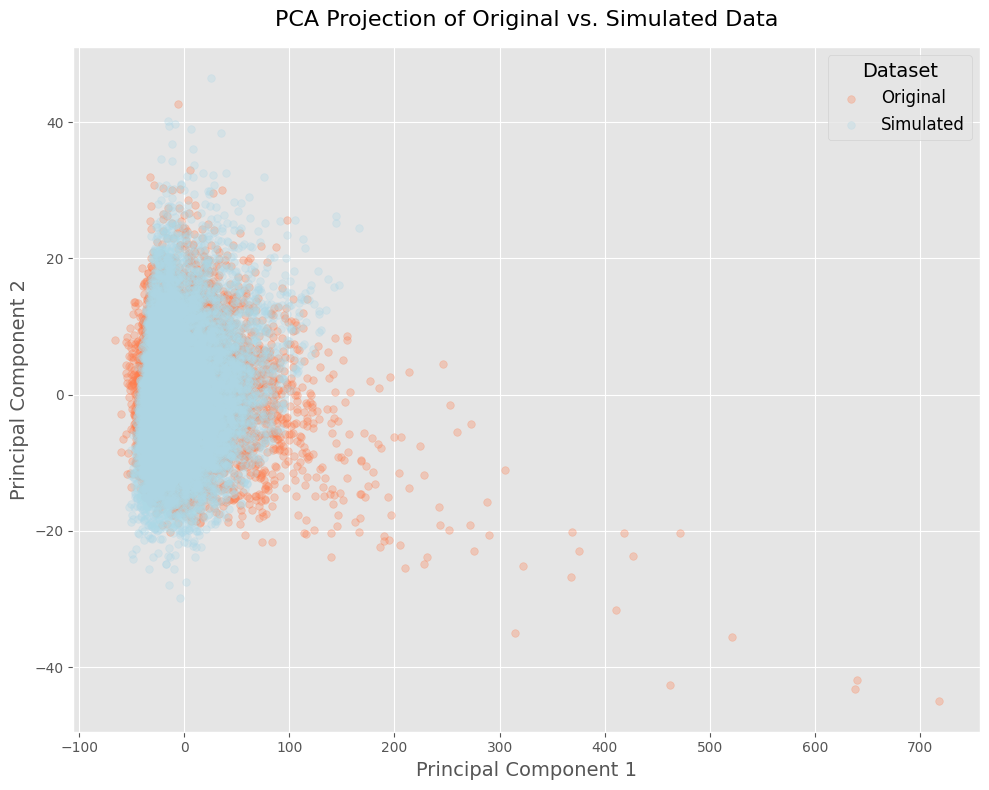

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Prepare the Data ---
# Label each DataFrame
original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

# Combine the two datasets
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

# --- Plotting ---
# Choose a clean style: try 'seaborn' if available, else use 'ggplot'
style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))

# Define colors: 'coral' for Original and 'lightblue' for Simulated.
colors = {'Original': 'coral', 'Simulated': 'lightblue'}

# Plot each dataset without edge colors
for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

# Set titles and labels with a modern font size
ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

# Customize the legend
ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()


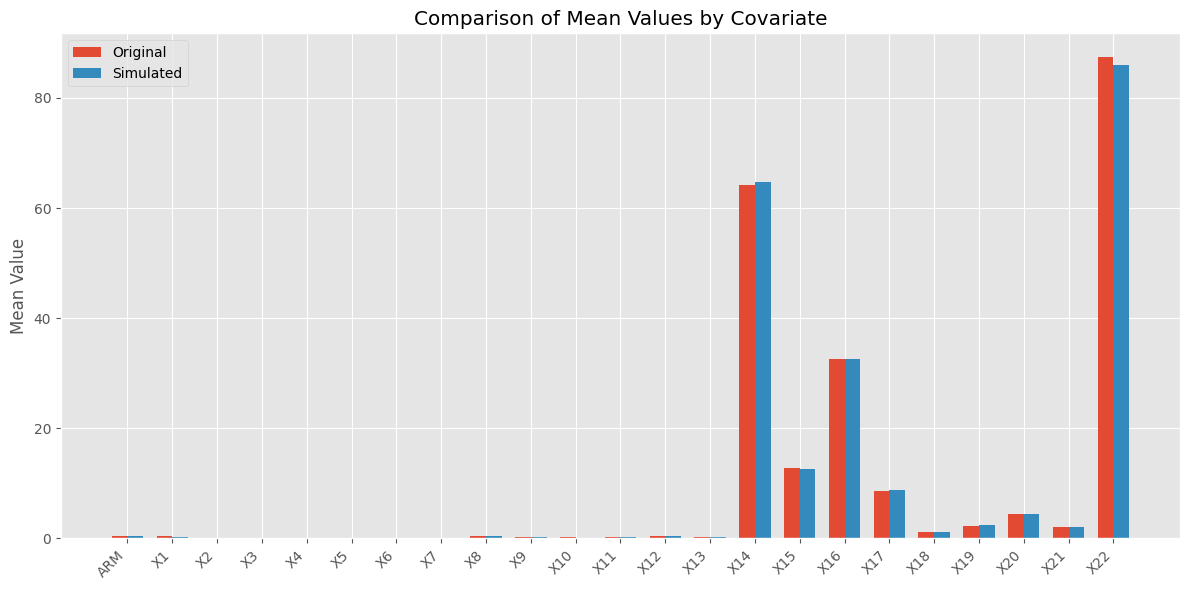

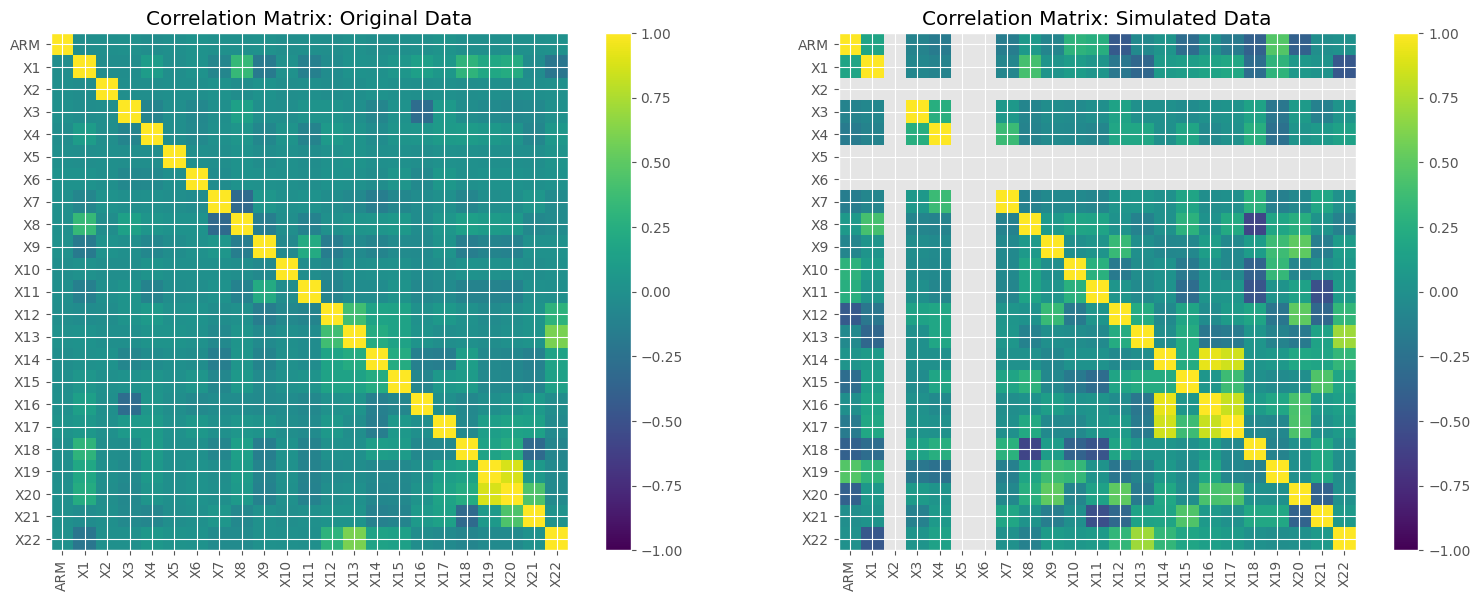

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.62      2749
           1       0.63      0.82      0.72      2749

    accuracy                           0.67      5498
   macro avg       0.69      0.67      0.67      5498
weighted avg       0.69      0.67      0.67      5498

Accuracy: 0.67
ROC AUC: 0.71


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

plt.style.use('ggplot')  # Use a beautiful built-in style
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

ax.set_xticks(x)
ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
ax.set_ylabel('Mean Value')
ax.set_title('Comparison of Mean Values by Covariate')
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 2. Dependency Structure Comparison
# ---------------------------
# Compute correlation matrices
corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# ---------------------------
# 3. Classifier to Distinguish Datasets
# ---------------------------
# For the classifier test, we create a new label column: 0 for original, 1 for simulated.
# First, copy the DataFrames to avoid modifying the originals.
orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [78]:
simulated_df.describe()

,ARM,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,9162.000000,9162.000000,9162.0,9162.000000,9162.000000,9162.0,9162.0,9162.000000,9162.000000,9162.000000,...,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000
mean,0.509823,0.319035,0.0,0.004366,0.002620,0.0,0.0,0.000218,0.385614,0.221567,...,0.220912,64.332405,12.813064,32.573116,8.730184,1.139901,2.344496,4.418109,2.057928,86.177391
std,0.499923,0.466143,0.0,0.065934,0.051119,0.0,0.0,0.014773,0.486751,0.415313,...,0.414896,7.808190,7.814526,6.419697,1.315899,0.851195,1.117835,0.945552,1.126409,29.962769
min,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,41.904919,-5.295317,15.303543,4.626021,-1.965241,-1.483290,1.508092,-2.003295,38.873295
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,58.788569,6.889176,27.910471,7.796015,0.567731,1.604423,3.757362,1.290560,64.545465
50%,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,63.895283,11.493271,31.968057,8.651093,1.132803,2.328984,4.374094,2.052282,78.769924
75%,1.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,...,0.000000,69.377798,17.539703,36.582146,9.570699,1.716336,3.087750,5.050053,2.827115,100.289179
max,1.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,...,1.000000,97.070190,51.434414,60.594845,13.705726,4.405279,6.334789,7.981648,6.112518,272.099182


In [79]:
original_df.describe()

,ARM,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,...,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000,9162.000000
mean,0.500546,0.356036,0.001201,0.100633,0.082624,0.000873,0.039074,0.120825,0.413447,0.306156,...,0.246671,64.277887,12.789446,32.492131,8.686881,1.175994,2.331628,4.406956,2.059103,87.372299
std,0.500027,0.478852,0.034631,0.300859,0.275328,0.029538,0.193783,0.325942,0.492478,0.460920,...,0.431097,7.201942,7.968244,6.276952,1.522112,0.318105,0.939283,1.171294,1.585316,38.950324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,49.000000,0.000000,17.100000,4.600000,0.080000,0.050000,1.660000,0.110000,20.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,60.000000,6.900000,28.100000,7.600000,0.960000,1.660000,3.590000,1.200000,65.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,64.000000,11.400000,31.700000,8.300000,1.140000,2.180000,4.225000,1.700000,79.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,69.000000,17.100000,36.000000,9.400000,1.350000,2.850000,5.050000,2.440000,99.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,88.000000,61.000000,81.000000,18.500000,3.990000,8.230000,20.070000,44.420000,806.000000
